In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd /content/gdrive/MyDrive/Springboard/Capstone-3/

In [3]:
# %pwd

In [4]:
# %ls

In [5]:
# !unzip -o chest-xray-pneumonia.zip -d /content/gdrive/MyDrive/Springboard/Capstone-3/

## Importing necessary libraries

In [6]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

## Dataset Structure:

- Three parent folders 'train', 'val', 'test'.
- Each folder contains two subfolders, 'NORMAL', and 'PNEUMONIA'.

I will import all three datasets to explore the sizes and class distribution.

In [7]:
#@title
# importing data
dataset_dir = 'chest_xray'
train_folder = os.path.join(dataset_dir, 'train')
val_folder = os.path.join(dataset_dir, 'val')
test_folder = os.path.join(dataset_dir, 'test')
im_size = 224

In [8]:
# defining a function to load images, resize, and convert to grayscale

def load_images(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        label = 'Normal' if subfolder == 'NORMAL' else 'Pneumonia'

        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (im_size, im_size))
            img = np.expand_dims(img, axis=-1) # adding back color channel
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [9]:
#@title
train_images, train_labels = load_images(train_folder)
val_images, val_labels = load_images(val_folder)
test_images, test_labels = load_images(test_folder)

In [10]:
#     # Use this to save variables
# import pickle

# with open('xray_data.pickle', 'wb') as f:
#   pickle.dump((train_images, test_images, train_labels, test_labels), f)

#     # Use this to load variables
# with open('xray_data.pickle', 'rb') as f:
#    (train_images, test_images, train_labels, test_labels) = pickle.load(f)

In [11]:
#@title
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape, val_images.shape, val_labels.shape
# (5216, 224, 224, 1) (5216,), (624, 224, 224, 1) (624,), (16, 224, 224, 1) (16,)

((5216, 224, 224, 1),
 (5216,),
 (624, 224, 224, 1),
 (624,),
 (16, 224, 224, 1),
 (16,))

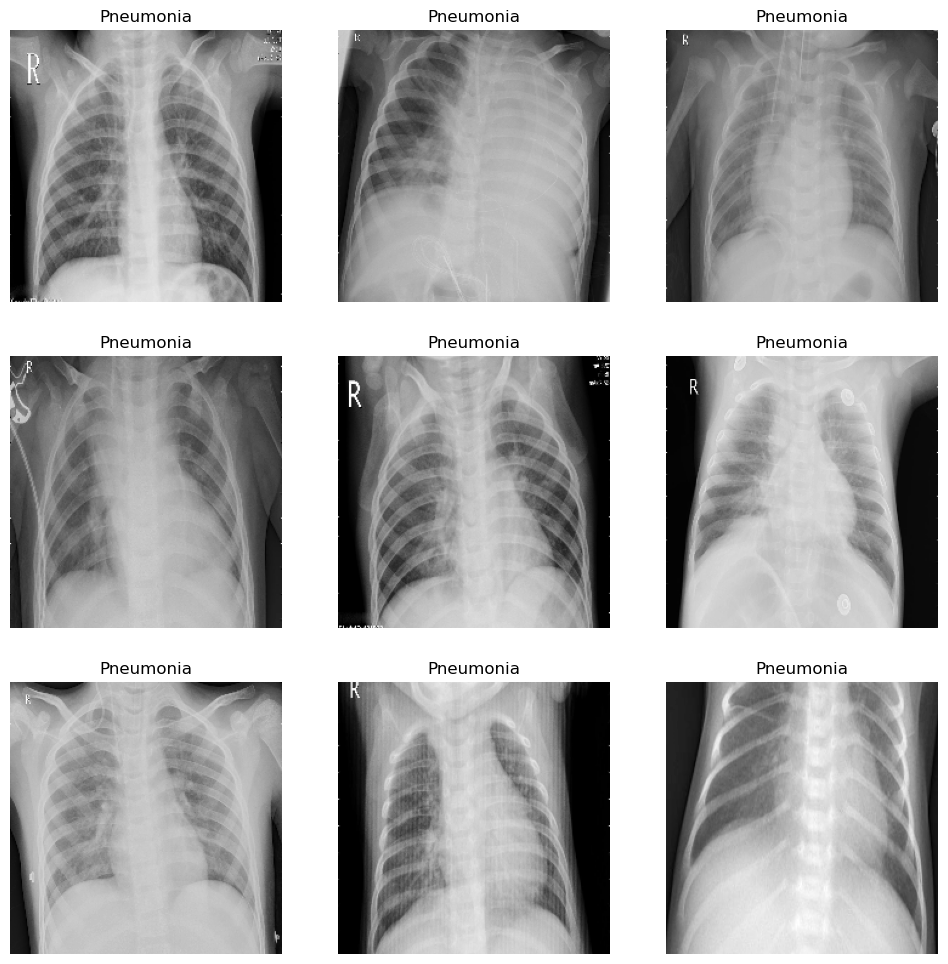

In [12]:
#@title
# visualizing the images

plt.figure(figsize=(12,12))
idx = list(np.random.randint(len(train_images), size=9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[idx[i]], cmap='gray')
    plt.title(train_labels[idx[i]])
    plt.axis('off')
plt.show()

In [13]:
print(np.asarray(np.unique(train_labels, return_counts=True)).T)

[['Normal' '1341']
 ['Pneumonia' '3875']]


In [14]:
print(np.asarray(np.unique(test_labels, return_counts=True)).T)

[['Normal' '234']
 ['Pneumonia' '390']]


## Data Augmentation using SMOTE

In [15]:
images_flattened = train_images.reshape(train_images.shape[0], -1)

from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [16]:
images_resampled, labels_resampled = smote.fit_resample(images_flattened, train_labels)

images_resampled = images_resampled.reshape(-1, train_images.shape[1], train_images.shape[2], train_images.shape[3])

images_resampled.shape, labels_resampled.shape

((7750, 224, 224, 1), (7750,))

In [17]:
np.unique(labels_resampled)

array(['Normal', 'Pneumonia'], dtype='<U9')

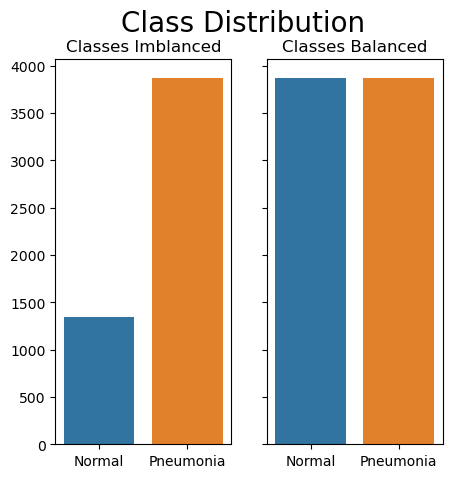

[1341 3875] [3875 3875]


In [18]:
unique1, counts1 = np.unique(train_labels, return_counts=True)
unique2, counts2 = np.unique(labels_resampled, return_counts=True)

fig, ax = plt.subplots(1,2, sharey=True,figsize=(5,5))
fig.suptitle('Class Distribution', fontsize=20)
sns.barplot(ax=ax[0], x=unique1, y=counts1)
ax[0].set_title('Classes Imblanced')
sns.barplot(ax=ax[1], x=unique2, y=counts2)
ax[1].set_title('Classes Balanced')
plt.xticks(range(len(unique1)), unique1)
plt.show()

print(counts1, counts2)

## Data encoding

Since this is a binary classification problem we can use Label Indexing.

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_labels_encoded = encoder.fit_transform(labels_resampled)
test_labels_encoded = encoder.fit_transform(test_labels)
val_labels_encoded = encoder.fit_transform(val_labels)

In [20]:
train_labels_encoded.shape

(7750,)

In [21]:
print(np.asarray(np.unique(train_labels_encoded, return_counts=True)).T)

[[   0 3875]
 [   1 3875]]


In [22]:
from tensorflow.keras.utils import to_categorical
train_labels_categorical = to_categorical(train_labels_encoded)
train_labels_categorical.shape

(7750, 2)

In [61]:
from sklearn.utils import shuffle
train_images_shuffled, train_labels_shuffled = shuffle(images_resampled, train_labels_categorical, random_state=42)

In [62]:
X_train = train_images_shuffled / 255.0
X_test = test_images / 255.0
X_val = val_images / 255.0

In [25]:
X_train.shape, X_test.shape

((7750, 224, 224, 1), (624, 224, 224, 1))

## Building the Model

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,MaxPool2D

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [28]:
input_shape = train_images[0].shape
num_classes = 2

compile

In [29]:
from tensorflow.keras.metrics import Precision, Recall
model = create_cnn_model(input_shape, num_classes)

METRICS = metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')]

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [31]:
from tensorflow.keras.models import load_model

model.save('model1.h5')

## Training the Model

In [32]:
# Define the number of epochs and batch size
epochs = 20
batch_size = 32

# Train the model
hist = model.fit(X_train, train_labels_shuffled, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
218/218 [==============================] - 17s 75ms/step - loss: 0.1823 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - val_loss: 0.0727 - val_accuracy: 0.9781 - val_precision: 0.9781 - val_recall: 0.9781
Epoch 2/20
218/218 [==============================] - 16s 74ms/step - loss: 0.0727 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - val_loss: 0.0953 - val_accuracy: 0.9639 - val_precision: 0.9639 - val_recall: 0.9639
Epoch 3/20
218/218 [==============================] - 16s 74ms/step - loss: 0.0627 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - val_loss: 0.0797 - val_accuracy: 0.9768 - val_precision: 0.9768 - val_recall: 0.9768
Epoch 4/20
218/218 [==============================] - 16s 74ms/step - loss: 0.0435 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - val_loss: 0.0610 - val_accuracy: 0.9845 - val_precision: 0.9845 - val_recall: 0.9845
Epoch 5/20
218/218 [==============================] - 16s 74ms/step - loss: 0.0335 - accuracy: 0

## Evaluating the model's performance

In [64]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

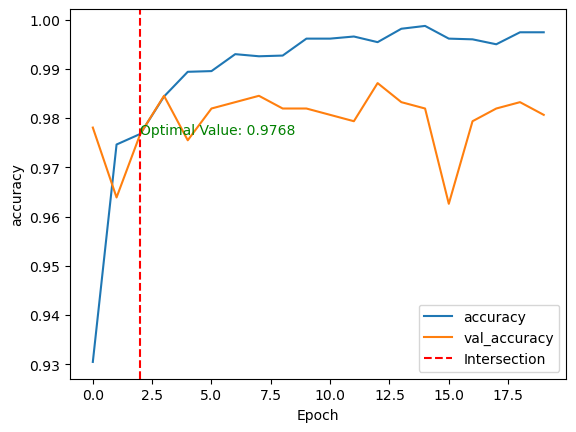

In [65]:
show_performance_curve(hist, 'accuracy', 'accuracy')

In [67]:
show_performance_curve(hist, 'loss', 'loss')

IndexError: index 0 is out of bounds for axis 0 with size 0

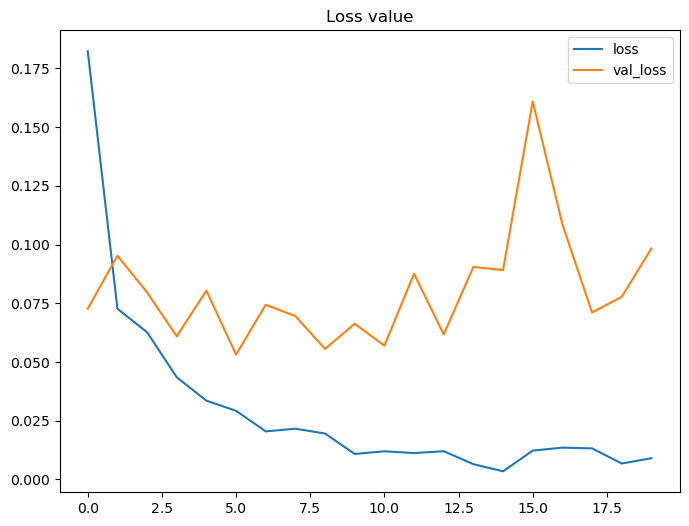

In [68]:
#Loss Graph
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Prediction evaluation

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [43]:
y_train = train_labels_shuffled
y_test = to_categorical(test_labels_encoded)

In [44]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, batch_size=32)

20/20 [==============================] - 1s 23ms/step - loss: 2.9750 - accuracy: 0.7244 - precision: 0.7244 - recall: 0.7244


[2.9749858379364014,
 0.7243589758872986,
 0.7243589758872986,
 0.7243589758872986]

In [45]:
#Test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(to_categorical(test_labels_encoded), axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

20/20 [==============================] - 0s 16ms/step
Accuracy:  0.7243589743589743
Precision:  0.6960431654676259
Recall:  0.9923076923076923
F1 Score:  0.8181818181818182


In [46]:
#Val data
y_pred_val = np.argmax(model.predict(X_val), axis=1)
y_val = np.argmax(to_categorical(val_labels_encoded), axis=1)

accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
# f1_score_val = f1_score(y_val, y_pred_val)

print("Accuracy: ", accuracy_val)
print("Precision: ", precision_val)
print("Recall: ", recall_val)
# print("F1 Score: ", f1_score_val)

1/1 [==============================] - 0s 23ms/step
Accuracy:  0.8125
Precision:  0.7272727272727273
Recall:  1.0


In [ ]:
# import tensorflow as tf
# tf.data.experimental.enable_debug_mode()

20/20 [==============================] - 0s 17ms/step


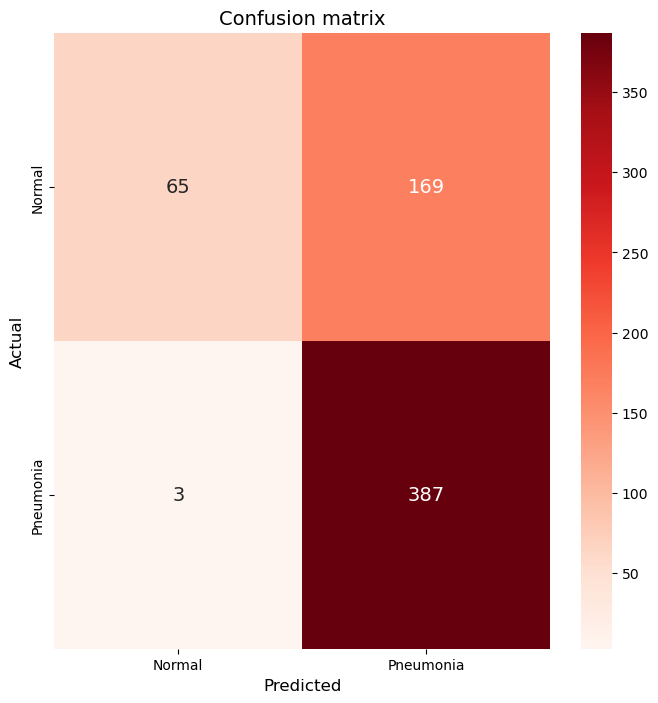

In [48]:
# Confusion Matrix
labels = ["Normal", "Pneumonia"]

#confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
# y_test = np.argmax(y_test, axis=1)

#transforming label back to original
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(y_test)
#matrix of Actual vs Prediction data
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix',fontsize=14)
sns.heatmap(
  c_matrix, xticklabels=labels,yticklabels=labels,
  fmt='d', annot=True,annot_kws={"size": 14}, cmap='Reds')
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.show()

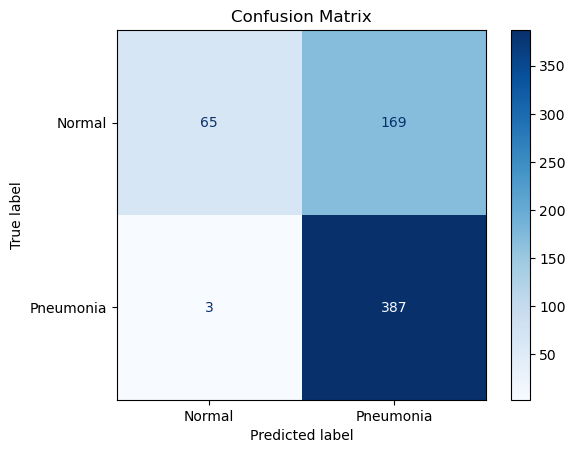

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# #@title

# for i in range(230,280,3):
#     pred = model.predict(X_test)[i]
#     #Display the x-ray image
#     plt.imshow("X-ray", test_images[i])
#     print("Actual :",y_test[i]," Predicted :",labels[np.argmax(pred)])